# Gesture Recognition using DL

<hr style="border:1px solid blue">

An assignment to train a Deep Learning (DL) model to recognize 5 hand gestures correctly when a user does a hand gesture in front of a web camera.

### Project Description

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.<br>
<br>
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:<br>
* **0** - Left swipe: 'Jump' backwards 10 seconds
* **1** - Right swipe: 'Jump' forward 10 seconds
* **2** - Stop: Pause the movie
* **3** - Thumbs down: Decrease the volume
* **4** - Thumbs up:  Increase the volume

#### Data Set Brief Information

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.<br>
<br>
The data is in a zip file. The zip file contains a 'train' and a 'val' folder with **two CSV files** for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains **30 frames (or images)**. Note that all images in a particular video subfolder have the same dimensions but **different videos may have different dimensions**. Specifically, videos have two types of dimensions - either **360x360** or **120x160** (depending on the webcam used to record the videos).<br>
<br>
Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.<br>

#### Business Objective
Use different architectures to build a DL model to classify 5 gestures correctly by training the model on the 'train' folder which performs well on the validation 'val' folder as well.

#### Business Solution
The trained model should be fit enough to be used in small web camera and identify the 5 gestures in real-time.

### Importing all the important libraries

In [1]:
# Import numpy
import numpy as np
# Import OS
import os
# Import imread and resize from skimage library
#from scipy.misc import imread, imresize # Latest scipy.misc version doesn't support imread and imresize
from skimage.io import imread
from skimage.transform import resize
# Import imageio library
import imageio
# Import datetime
import datetime

`We set the random seed so that the results don't vary drastically.`

In [2]:
# Set numpy random seed to 30
np.random.seed(30)
# Set random seed to 30
import random as rn
rn.seed(30)
# Import keras and tensorflow
#from keras import backend as K
import tensorflow as tf
from tensorflow import keras
# Set tensorflow random seed to 30
#tf.set_random_seed(30) # Latest tensorflow version doesn't support set_random_seed()
tf.random.set_seed(30)

In [3]:
# Import models, layers, callbacks, optimizers and load_model from keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.models import load_model

In [4]:
# Importing matplotlib library
import matplotlib.pyplot as plt
# Import gridspec for plotting detailed graph
import matplotlib.gridspec as gridspec
# To enable the inline plotting
%matplotlib inline
# Set tensorflow log level to report only ERROR - this removes warning created by image augmentation layer in model
tf.get_logger().setLevel('ERROR')
# Ignore warnings due to library versions
import warnings
warnings.filterwarnings("ignore")
# Import metrics from sklearn library
from sklearn import metrics
# Import libraries for defining Abstract class
from abc import ABCMeta, abstractmethod
# Import Open-CV
import cv2
# Import gridspec for plotting detailed graph
import matplotlib.gridspec as gridspec

`Function to plot model performance.`

In [5]:
# Function to plot model performance on training and validation dataset
def plot_model_outcome(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(7, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [6]:
# Specify a folder path
fpath = 'datasets/Project_data'

# Gesture Class names per index
class_names = ['Left swipe', 'Right swipe', 'Stop: Pause', 'Thumbs down', 'Thumbs up']

### Data Analysis
* Each video contains 30 frames
* Frame is either 360x360 or 120x160 resolution
* RGB colour image - 3 channels
* Train dataset have 663 images

#### Memory Calculation
* If we go for high resolution (360x360) and 30 frames per video, for a batch size of 32, it will be around:<br>
  = (Image Height x Image Width x Channels x Images per Video x Total Dataset) / (1 GB in Bytes)<br>
  = (360 x 360 x 3 x 30 x 663) / (1024 x 1024 x 1024)<br>
  = ~**7 GB**<br>
  This will eat up memory if we have greater than 1 million params in designed model. And, also it requires more time to train.
* If we go for lower resolution (120x160) and 30 frames per video, for a batch size of 32, it will be around ~**1 GB**. This we could manage further down by adjusting images per video and resolution.
* Batch size doesn't matter in terms of memory, since we will train for entire 663 dataset! The only thing it affects is the speed of training per epoch. If batch size is more, then number of batch data per epoch will be reduced.
* We have huge dataset, so we need to adjust memory and speed to get good amount of accuracy and also the model should fit in web camera for real-time classification.

### Base Model Class to instantiate different models and adjust parameters for training

Instead of defining as functions (**as given in starter code**), we will define a base class to  instantiate different models and adjust parameters for training. The base class will have abstract method to define required model for training!<br>
This will ease the engineer to design the DL models efficiently.<br>
Since we have huge dataset, we will use generator function to generate data per batch using yield function.

In [7]:
# Base Class
class BaseModel(metaclass=ABCMeta):
    # Initialization function
    # arguments:
    #    fpath (main folder path in JarvisAI : 'datasets/Project_data')
    def init(self, fpath = 'datasets/Project_data'):
        # Open CSV file containing training dataset information
        self.train_doc = np.random.permutation(open(fpath + '/train.csv').readlines())
        # Open CSV file containing validation dataset information
        self.val_doc = np.random.permutation(open(fpath + '/val.csv').readlines())
        # Folder path containing training dataset
        self.train_path = fpath + '/train'
        # Folder path containing validation dataset
        self.val_path = fpath + '/val'
        # We have 3 channels (RGB), 5 Gesture classes, 30 images per folder
        self.channels = 3
        self.num_classes = 5
        self.total_imgs = 30
        # Get number of available training and validation datasets
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        print('Total training dataset : ', self.num_train_sequences)
        print('Total validation dataset : ', self.num_val_sequences)

    # Parameter function
    # arguments:
    #    img_height (Image Height : Default(120))
    #    img_width (Image Width : Default(160))
    #    batch_size (Batch Size : Default(20))
    #    num_epochs (Number of Epochs : Default(20))
    #    imgs_to_use (Number of Images to use per video : Default(30))
    def params(self, img_height = 120, img_width = 160, batch_size = 20, num_epochs = 20, imgs_to_use = 30):
        # Update all parameters assigned by user
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.imgs_to_use = imgs_to_use

    # Generator function
    # arguments:
    #    source_path (Source Path of folder)
    #    folder_list (Folder List containing CSV information)
    #    augment (To augment the dataset : Default(False))
    def generator(self, source_path, folder_list, augment = False):
        print( 'Source path = ', source_path, '; batch size =', self.batch_size)
        # List of image indexes to be used. From 30 images per folder, create indexes as required by user evenly spaced.
        img_idx = np.round(np.linspace(0, (self.total_imgs - 1), self.imgs_to_use)).astype(int)
        while True:
            t = np.random.permutation(folder_list) # Get random list of folders
            num_batches = len(t)//self.batch_size # Calculate the number of batches
            remaining_len = len(t)%self.batch_size # Calculate remaining leftover length
            
            # Generate batch data and labels using yield command
            for batch in range(num_batches): # Iterate over the number of batches
                batch_data, batch_labels = self.__generate(source_path, img_idx, t, batch, self.batch_size, augment)
                yield batch_data, batch_labels
            
            # Generate batch data and labels for remaining leftover length
            if (remaining_len != 0):
                batch_data, batch_labels = self.__generate(source_path, img_idx, t, num_batches, remaining_len, augment)
                yield batch_data, batch_labels

    # Generate function (Private)
    # arguments:
    #    source_path (Source Path of folder)
    #    img_idx (Image indexes)
    #    t (Random list of folders)
    #    batch (Current batch)
    #    batch_len (Total batch length)
    #    augment (To augment the dataset : Default(False))
    def __generate(self, source_path, img_idx, t, batch, batch_len, augment = False):
        # Batch data is of shape (batch size, images per video, image height, image width, RGB channels)
        batch_data = np.zeros((batch_len, len(img_idx), self.img_height, self.img_width, self.channels))
        # Batch_labels is the one hot representation of the output. Shape is (batch size, 5 Gesture class)
        batch_labels = np.zeros((batch_len, self.num_classes))
        
        # If user opted augment data, create augmented batch data of shape:
        # (batch size, images per video, image height, image width, RGB channels)
        if(augment):
            batch_data_aug = np.zeros((batch_len, len(img_idx), self.img_height, self.img_width, self.channels))
        
        for folder in range(batch_len): # Iterate over the batch_size
            # Read all the image info available in the random permuted list
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*self.batch_size)].split(';')[0])
            
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                # Read particular image from current folder
                image = imread(source_path+'/'+ t[folder + (batch*self.batch_size)].strip().split(';')[0]+'/'+ imgs[item]).astype(np.float32)
                # Resize image
                resize_image = resize(image, (self.img_height, self.img_width, self.channels))
                        
                # Normalize the image by dividing by 255
                batch_data[folder,idx,:,:,0] = (resize_image[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (resize_image[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (resize_image[:,:,2])/255
                
                # If user opted augment data, create augmented batch data
                if (augment):
                    # Randomly shift the image to nudge it from frame of (height, width) in either of 4 directions.
                    # When image is nudged, the leftover area is painted raw.
                    shifted_image = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    # OpenCV colour channels are converted to gray
                    gray_image = cv2.cvtColor(shifted_image, cv2.COLOR_BGR2GRAY)

                    # Identify the black region
                    x0, y0 = np.argwhere(gray_image > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray_image > 0).max(axis=0) 

                    # Crop image by removing black region
                    cropped_image = shifted_image[x0:x1,y0:y1,:]

                    # Resize image
                    resize_image = resize(cropped_image, (self.img_height, self.img_width, self.channels))

                    # Normalize the image by dividing by 255
                    batch_data_aug[folder,idx,:,:,0] = (resize_image[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (resize_image[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (resize_image[:,:,2])/255
            
            # Create batch labels from image info available in the random permuted list
            batch_labels[folder, int(t[folder + (batch*self.batch_size)].strip().split(';')[2])] = 1

        # If user opted augment data, append augmented batch data with original batch data 
        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug]) # Concatenate batch data
            batch_labels = np.concatenate([batch_labels, batch_labels]) # Labels are same since we augmented same image

        return (batch_data, batch_labels)

    # Training function
    # arguments:
    #    model (Deep Learning Model for training)
    #    augment (To augment the dataset : Default(False))
    #    save_best_only (Save only best model : Default(False))
    #    stop_patience (Patience for Early Stopping : Default(4))
    def train(self, model, augment = False, save_best_only = True, stop_patience = 4):
        # Get training dataset generator
        train_generator = self.generator(self.train_path, self.train_doc, augment)
        # Get validation dataset generator
        val_generator = self.generator(self.val_path, self.val_doc)
        # Create model name for storage purpose
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        
        # Create folder name as model for storing all model weights per epoch runs or save best model.
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        # Create file path
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        # Create check point function to save model params
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=save_best_only, save_weights_only=False, mode='auto', period=1)
        # Reduce learning rate as model progress per epoch run
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        # Stop early if model validation loss doesn't improve after some epoch run
        earlystop = EarlyStopping(monitor="val_loss", patience=stop_patience, verbose=1)
        # Create callback function list
        callbacks_list = [checkpoint, LR, earlystop]
        
        # Get steps per epoch for training and validation dataset
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        # Fit the model
        history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        # Return model history
        return history
    
    # Abstract class for creating the required model to be trained
    @abstractmethod
    def create(self):
        pass

## Model 1

We will create a 3D Convolutional model with custom trainable params. This will help us to avoid re-writing same code again. Also different params can affect the model performance in terms of memory and speed.<br>
Since the dataset require some good amount of memory, we will design 3D Convolutional model to break down the params maximum to fit and get good accuracy.

#### Model Design
* A convolution layer (Conv3D) having 16, 32, 64 and 128 kernels with Relu activation function is designed. The output image resolution is kept same.
* Between each convolution layer:
    * A max pooling layer (MaxPooling3D) is added to reduce dimensionality.
    * A dropout layer (Dropout) is added to reguralize and avoid overfitting of model
* The output convolution-max pooling layer is flattened using Flatten layer.
* Two fully connected layers (Dense) with Relu activation function is added. And two dropout layer is added in between them. If the first dense layer have `x` neurons, then second dense layer will have `x/2` neurons.
* Finally a fully connected layer with 5 neurons with Softmax activation function is used to classify the sequence in to one of the 5 Gesture classes.

In [8]:
# Child class inherits properties from base abstract class and define the model creation functio 'create'
class Model3D_1(BaseModel):
    # Model function
    # arguments:
    #    kernel_size (Kernel Filter Shape : Default((3, 3, 3)))
    #    pool_size (Pool Size Shape : Default((2, 2, 2)))
    #    fc_neurons (Number of neurons in Fully Connected Layer : Default(64))
    #    dropout_rate (Dropout rate in Dropout Layer : Default(0.25))
    #    optimiser (Optimiser to be used : Default(Adam with Learning Rate 0.001))
    def create(self, 
               kernel_size = (3, 3, 3), 
               pool_size = (2, 2, 2), 
               fc_neurons = 64, 
               dropout_rate = 0.25, 
               optimiser = tf.optimizers.Adam()):
        model = Sequential()
        
        # First conv layer
        model.add(Conv3D(16, kernel_size=kernel_size, padding='same', activation='relu',
                 input_shape=(self.imgs_to_use, self.img_height, self.img_width, self.channels)))
        # First max pool layer
        model.add(MaxPooling3D(pool_size=pool_size))
        # First Dropout layer
        model.add(Dropout(dropout_rate))
        
        # Second conv layer
        model.add(Conv3D(32, kernel_size=kernel_size, padding='same', activation='relu'))
        # Second max pool layer
        model.add(MaxPooling3D(pool_size=pool_size))
        # Second Dropout layer
        model.add(Dropout(dropout_rate))

        # Third conv layer
        model.add(Conv3D(64, kernel_size=kernel_size, padding='same', activation='relu'))
        # Third max pool layer
        model.add(MaxPooling3D(pool_size=pool_size))
        # Third Dropout layer
        model.add(Dropout(dropout_rate))

        # Fourth conv layer
        model.add(Conv3D(128, kernel_size=kernel_size, padding='same', activation='relu'))
        # Fourth max pool layer
        model.add(MaxPooling3D(pool_size=pool_size))
        # Fourth Dropout layer
        model.add(Dropout(dropout_rate))

        # Flatten layer
        model.add(Flatten())

        # Dense layer or fully connected layer
        model.add(Dense(fc_neurons, activation='relu'))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Dense layer or fully connected layer
        model.add(Dense(fc_neurons//2, activation='relu'))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Softmax layer
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

## Visualize Image

Visualize one image from batch to see if our class is working fine. This will help us to verify yield function works properly or not.

Total training dataset :  663
Total validation dataset :  100
Source path =  datasets/Project_data/train ; batch size = 5


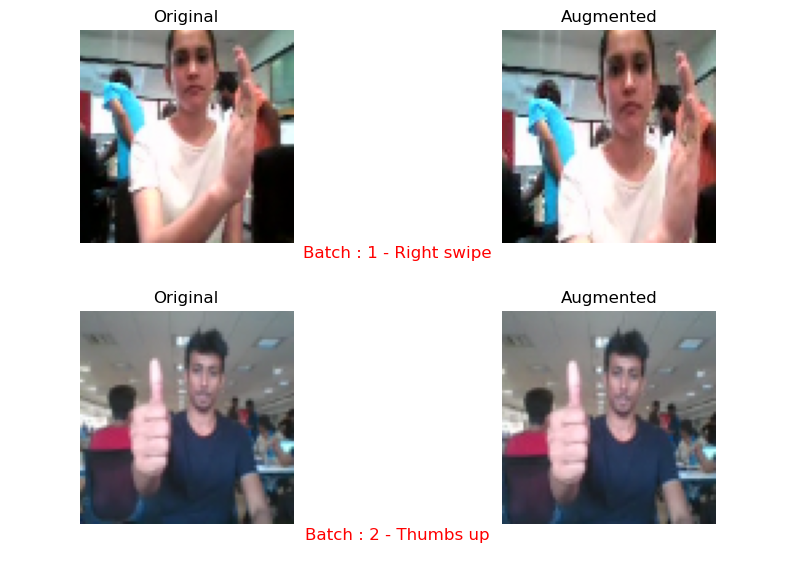

In [9]:
# Create a temporary model and visualize one batch data
test_obj = Model3D_1()
test_obj.init(fpath)
test_obj.params(img_height = 80, img_width = 80, batch_size = 5)
# Yield Generator
yield_obj = test_obj.generator(test_obj.train_path, test_obj.train_doc, augment = True)

fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(4, 2, height_ratios=[2, 0.2, 2, 0.2])
m_row = 0

for i in range(2):
    batch_data, batch_labels = next(yield_obj)

    ax_org = fig.add_subplot(gs[m_row, 0])
    ax_aug = fig.add_subplot(gs[m_row, 1])
    ax_sup = fig.add_subplot(gs[(m_row + 1), 0:2])

    ax_org.imshow(batch_data[0,10,:,:,:])
    ax_aug.imshow(batch_data[5,10,:,:,:])

    ax_org.set_title("Original")
    ax_org.axis("off")
    ax_aug.set_title("Augmented")
    ax_aug.axis("off")
    ax_sup.set_title("Batch : " + str(i + 1) + " - " + class_names[np.argmax(batch_labels[0])], color='r')
    ax_sup.axis("off")

    m_row += 2
    del batch_data, batch_labels

# Delete the objects and variables to save memory!
del test_obj, yield_obj

#### Model 1 Summary
* Image resolution of 120x160 is chosen and 30 images per Video is taken for training the model. 17 sequences per 39 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3, 3), Max Pool shape is (2, 2, 2), Two dense layer with 64 and 32 neurons, dropout rate is 0.25 and optimizer is Adam with learning rate 0.001

In [10]:
# Create a object of Model3D_1()
# Params:
#   Image Shape - (120, 160)
#   Batch Size - 39
#   Epochs - 20
#   Images per Video - 30
model3D_1_obj = Model3D_1()
model3D_1_obj.init(fpath)
model3D_1_obj.params(img_height = 120, img_width = 160, batch_size = 39, num_epochs = 20, imgs_to_use = 30)
model3D_1 = model3D_1_obj.create()

Total training dataset :  663
Total validation dataset :  100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 160, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 80, 16)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 60, 80, 16)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 80, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 30, 40, 32)    0         
 3D)                                                             
                                                            

2023-02-12 16:13:47.373689: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-12 16:13:47.373759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


##### Model 1 Param Calculation
Let's do some calculations to verify that we understand the model deeply enough. The first element None is for the batch size (39).<br>
The output size is calculated using `(((N + (2 * P) - K) / S) + 1)`, where:
* N => Input Shape size
* P => Padding value
* K => Kernal size
* S => Stride value<br>
<br>

The trainable params can be calculated using `Weights + Bias'<br>

* Input shape is (None, 30, 120, 160, 3). Here 3 is RGB channel count. The dropout layers doesn't change shape of sequence. The dropout, flatten and max poolig layer have no params to train.
* Output shape of 1st Convolution layer remains shape expect for channel count. The channels are replaced by 16 features with params to train = (3 channels x 16 kernels x (3 x 3 x 3) kernel Shape + 16 Bias) = 1312
* Output shape of 1st Max Pooling layer can be calculated using above formula:
    * Images per video = (((30 + (2 * 0) - 2) / 2) + 1) = 15
    * Image Height = (((120 + (2 * 0) - 2) / 2) + 1) = 60
    * Image Width = (((160 + (2 * 0) - 2) / 2) + 1) = 80
* Output shape of 2nd Convolution layer have 32 features with params to train = (16 features x 32 kernels x (3 x 3 x 3) kernel Shape + 32 Bias) = 13856
* Output shape of 2nd Max Pooling layer can be calculated as:
    * Images per video = (((15 + (2 * 0) - 2) / 2) + 1) = 7
    * Image Height = (((60 + (2 * 0) - 2) / 2) + 1) = 30
    * Image Width = (((80 + (2 * 0) - 2) / 2) + 1) = 40
* Output shape of 3rd Convolution layer have 64 features with params to train = (32 features x 64 kernels x (3 x 3 x 3) kernel Shape + 64 Bias) = 55360
* Output shape of 3rd Max Pooling layer can be calculated as:
    * Images per video = (((7 + (2 * 0) - 2) / 2) + 1) = 3
    * Image Height = (((30 + (2 * 0) - 2) / 2) + 1) = 15
    * Image Width = (((40 + (2 * 0) - 2) / 2) + 1) = 20
* Output shape of 4th Convolution layer have 128 features with params to train = (64 features x 128 kernels x (3 x 3 x 3) kernel Shape + 128 Bias) = 221312
* Output shape of 4th Max Pooling layer can be calculated as:
    * Images per video = (((3 + (2 * 0) - 2) / 2) + 1) = 1
    * Image Height = (((15 + (2 * 0) - 2) / 2) + 1) = 7
    * Image Width = (((20 + (2 * 0) - 2) / 2) + 1) = 10
* Output shape of flatten layer is (1 x 7 x 10 x 128) = 8960
* Output shape of 1st dense layer is 64 with param to train = (8960 x 64) + 64 = 573504
* Output shape of 2nd dense layer is 32 with param to train = (64 x 32) + 32 = 2080
* Output shape of SoftMax dense layer is 5 with param to train = (32 x 5) + 5 = 165

Source path =  datasets/Project_data/train ; batch size = 39
Epoch 1/20


2023-02-12 16:13:58.381922: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.6306 - categorical_accuracy: 0.1900Source path =  datasets/Project_data/val ; batch size = 39

Epoch 00001: val_loss improved from inf to 1.60912, saving model to model_init_2023-02-1216_13_47.497290/model-00001-1.63057-0.19005-1.60912-0.21000.h5
17/17 [==============================] - 167s 10s/step - loss: 1.6306 - categorical_accuracy: 0.1900 - val_loss: 1.6091 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1900
Epoch 00002: val_loss did not improve from 1.60912
17/17 [==============================] - 166s 10s/step - loss: 1.6095 - categorical_accuracy: 0.1900 - val_loss: 1.6097 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.6043 - categorical_accuracy: 0.1991
Epoch 00003: val_loss improved from 1.60912 to 1.57706, saving model to model_init_2023-02-1216

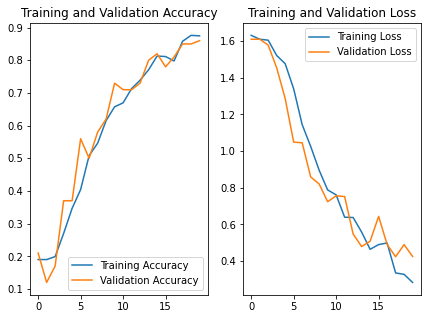

In [11]:
# Train model and plot performance
model3D_1_hist = model3D_1_obj.train(model3D_1)
plot_model_outcome(model3D_1_hist)

# Delete the objects and variables to save memory!
del model3D_1_obj, model3D_1_hist, model3D_1

##### Model 1 Training Summary
Validation loss didn't improve that much after 18th epoch. Since we save only the best model to reduce memory usage:<br>
* Training Accuracy - **85.82** %
* Training Loss - **0.35**
* Validation Accuracy - **85** %
* Validation Loss - **0.42**

This model is little bit heavy but still manageable and metrics is acceptable for testing real-time predictions.

## Model 2

#### Model 2 Summary
Let's reduce number of images per video and increase the neurons in dense layer.

* Image resolution of 120x160 is chosen and 17 images per Video is taken for training the model. 17 sequences per 39 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3, 3), Max Pool shape is (2, 2, 2), Two dense layer with 256 and 128 neurons, dropout rate is 0.5 and optimizer is Adam with learning rate 0.001

`Similar to model 1 param calculation, we can calculate the output shape and trainable params of this model as well.`

In [ ]:
# Create a object of Model3D_1()
# Params:
#   Image Shape - (120, 160)
#   Batch Size - 39
#   Epochs - 20
#   Images per Video - 17
#   Fully Connected Neurons - 256
#   Dropout Rate - 0.5
model3D_2_obj = Model3D_1()
model3D_2_obj.init(fpath)
model3D_2_obj.params(img_height = 120, img_width = 160, batch_size = 39, num_epochs = 20, imgs_to_use = 17)
model3D_2 = model3D_2_obj.create(fc_neurons = 256, dropout_rate = 0.5)

Total training dataset :  663
Total validation dataset :  100
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 17, 120, 160, 16)  1312      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 80, 16)    0         
 3D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 8, 60, 80, 16)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 80, 32)     13856     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 4, 30, 40, 32)    0         
 3D)                                                             
                                                          

Source path =  datasets/Project_data/train ; batch size = 39
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.8823 - categorical_accuracy: 0.2157Source path =  datasets/Project_data/val ; batch size = 39

Epoch 00001: val_loss improved from inf to 1.60896, saving model to model_init_2023-02-1217_08_37.897273/model-00001-1.88232-0.21569-1.60896-0.21000.h5
17/17 [==============================] - 95s 6s/step - loss: 1.8823 - categorical_accuracy: 0.2157 - val_loss: 1.6090 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.6112 - categorical_accuracy: 0.1991
Epoch 00002: val_loss improved from 1.60896 to 1.60189, saving model to model_init_2023-02-1217_08_37.897273/model-00002-1.61120-0.19910-1.60189-0.38000.h5
17/17 [==============================] - 95s 6s/step - loss: 1.6112 - categorical_accuracy: 0.1991 - val_loss: 1.6019 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 3/20
17/17 [==========

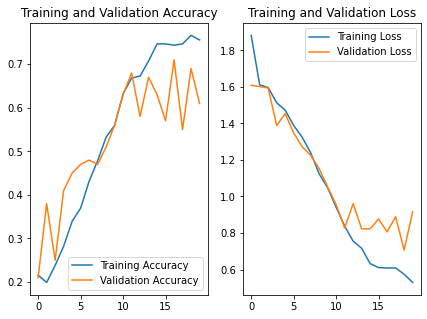

In [ ]:
# Train model and plot performance
model3D_2_hist = model3D_2_obj.train(model3D_2)
plot_model_outcome(model3D_2_hist)

# Delete the objects and variables to save memory!
del model3D_2_obj, model3D_2_hist, model3D_2

##### Model 2 Training Summary
Metrics:
* Training Accuracy - **76.62** %
* Training Loss - **0.57**
* Validation Accuracy - **69** %
* Validation Loss - **0.71**

This model ran faster than model 1 but metrics is low. It can be because of reduction in images per video or might be due to 0.5 droprate

## Model 3

#### Model 3 Summary
* Image resolution of 120x160 is chosen and 17 images per Video is taken for training the model. 17 sequences per 39 batches will be fed to the model per 20 epochs!
* Kernel shape is (2, 2, 2), Max Pool shape is (2, 2, 2), Two dense layer with 256 and 128 neurons, dropout rate is 0.25 and optimizer is Adam with learning rate 0.002

`Similar to model 1 param calculation, we can calculate the output shape and trainable params of this model as well.`

In [ ]:
# Create a object of Model3D_1()
# Params:
#   Image Shape - (120, 160)
#   Batch Size - 39
#   Epochs - 20
#   Images per Video - 17
#   Kernel Shape - (2, 2, 2)
#   Fully Connected Neurons - 256
#   Learning Rate - 0.002
model3D_3_obj = Model3D_1()
model3D_3_obj.init(fpath)
model3D_3_obj.params(img_height = 120, img_width = 160, batch_size = 39, num_epochs = 20, imgs_to_use = 17)
model3D_3 = model3D_3_obj.create(kernel_size = (2, 2, 2), fc_neurons = 256, 
                                 optimiser = tf.optimizers.Adam(learning_rate = 0.002))

Total training dataset :  663
Total validation dataset :  100
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 17, 120, 160, 16)  400       
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 80, 16)    0         
 3D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 8, 60, 80, 16)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 80, 32)     4128      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 4, 30, 40, 32)    0         
 3D)                                                             
                                                          

Source path =  datasets/Project_data/train ; batch size = 39
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.8455 - categorical_accuracy: 0.2217Source path =  datasets/Project_data/val ; batch size = 39

Epoch 00001: val_loss improved from inf to 1.60783, saving model to model_init_2023-02-1217_40_00.510120/model-00001-1.84549-0.22172-1.60783-0.38000.h5
17/17 [==============================] - 94s 6s/step - loss: 1.8455 - categorical_accuracy: 0.2217 - val_loss: 1.6078 - val_categorical_accuracy: 0.3800 - lr: 0.0020
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.6016 - categorical_accuracy: 0.2006
Epoch 00002: val_loss improved from 1.60783 to 1.60038, saving model to model_init_2023-02-1217_40_00.510120/model-00002-1.60164-0.20060-1.60038-0.48000.h5
17/17 [==============================] - 94s 6s/step - loss: 1.6016 - categorical_accuracy: 0.2006 - val_loss: 1.6004 - val_categorical_accuracy: 0.4800 - lr: 0.0020
Epoch 3/20
17/17 [==========

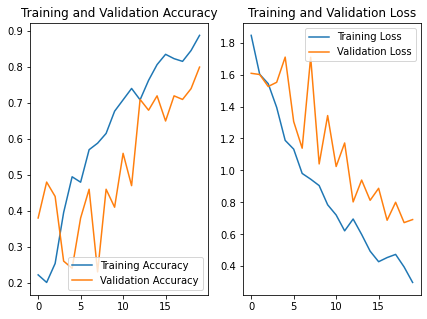

In [ ]:
# Train model and plot performance
model3D_3_hist = model3D_3_obj.train(model3D_3)
plot_model_outcome(model3D_3_hist)

# Delete the objects and variables to save memory!
del model3D_3_obj, model3D_3_hist, model3D_3

##### Model 3 Training Summary
Metrics:
* Training Accuracy - **84.62** %
* Training Loss - **0.40**
* Validation Accuracy - **74** %
* Validation Loss - **0.67**

This model is faster but from **model plot**, it looks overfitting. It can be because of reduction in images per video or reduction of kernel size.

## Model 4

#### Model 4 Summary
* Image resolution of 120x120 is chosen and 20 images per Video is taken for training the model. 17 sequences per 39 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3, 3), Max Pool shape is (2, 2, 2), Two dense layer with 128 and 64 neurons, dropout rate is 0.25 and optimizer is Adam with learning rate 0.002

`Similar to model 1 param calculation, we can calculate the output shape and trainable params of this model as well.`

In [ ]:
# Create a object of Model3D_1()
# Params:
#   Image Shape - (120, 120)
#   Batch Size - 39
#   Epochs - 20
#   Images per Video - 20
#   Fully Connected Neurons - 128
#   Learning Rate - 0.002
model3D_4_obj = Model3D_1()
model3D_4_obj.init(fpath)
model3D_4_obj.params(img_height = 120, img_width = 120, batch_size = 39, num_epochs = 20, imgs_to_use = 20)
model3D_4 = model3D_4_obj.create(fc_neurons = 128, optimiser = tf.optimizers.Adam(learning_rate = 0.002))

Total training dataset :  663
Total validation dataset :  100
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 10, 60, 60, 16)    0         
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 5, 30, 30, 32)    0         
 g3D)                                                            
                                                          

Source path =  datasets/Project_data/train ; batch size = 39
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.6326 - categorical_accuracy: 0.2247Source path =  datasets/Project_data/val ; batch size = 39

Epoch 00001: val_loss improved from inf to 1.60997, saving model to model_init_2023-02-1218_10_47.493118/model-00001-1.63257-0.22474-1.60997-0.18000.h5
17/17 [==============================] - 102s 6s/step - loss: 1.6326 - categorical_accuracy: 0.2247 - val_loss: 1.6100 - val_categorical_accuracy: 0.1800 - lr: 0.0020
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.1916
Epoch 00002: val_loss did not improve from 1.60997
17/17 [==============================] - 100s 6s/step - loss: 1.6092 - categorical_accuracy: 0.1916 - val_loss: 1.6114 - val_categorical_accuracy: 0.1500 - lr: 0.0020
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.5272 - categorical_accuracy: 0.2775
Epoch 00006: val_loss imp

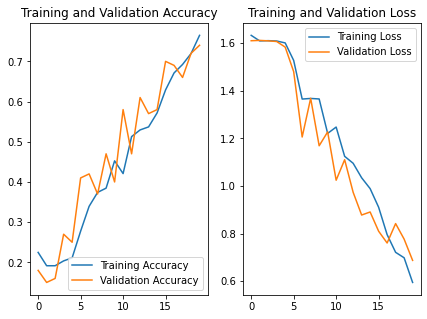

In [ ]:
# Train model and plot performance
model3D_4_hist = model3D_4_obj.train(model3D_4)
plot_model_outcome(model3D_4_hist)

# Delete the objects and variables to save memory!
del model3D_4_obj, model3D_4_hist, model3D_4

##### Model 4 Training Summary
Metrics:
* Training Accuracy - **76.47** %
* Training Loss - **0.59**
* Validation Accuracy - **74** %
* Validation Loss - **0.69**

This model is better when compared to model 3. But metric is lower than model 1.<br>
Validation accuracy and loss keeps on dropping and increasing per epoch. This could mean the model is trying hard to get stable results.

## Model 5

#### Model 5 Summary
* Image resolution of 100x100 is chosen and 25 images per Video is taken for training the model. 17 sequences per 39 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3, 3), Max Pool shape is (2, 2, 2), Two dense layer with 64 and 32 neurons, dropout rate is 0.25 and optimizer is Adam with learning rate 0.002

`Similar to model 1 param calculation, we can calculate the output shape and trainable params of this model as well.`

In [ ]:
# Create a object of Model3D_1()
# Params:
#   Image Shape - (100, 100)
#   Batch Size - 39
#   Epochs - 20
#   Images per Video - 25
#   Learning Rate - 0.002
model3D_5_obj = Model3D_1()
model3D_5_obj.init(fpath)
model3D_5_obj.params(img_height = 100, img_width = 100, batch_size = 39, num_epochs = 20, imgs_to_use = 25)
model3D_5 = model3D_5_obj.create(optimiser = tf.optimizers.Adam(learning_rate = 0.002))

Total training dataset :  663
Total validation dataset :  100
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 25, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 12, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 12, 50, 50, 16)    0         
                                                                 
 conv3d_17 (Conv3D)          (None, 12, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 6, 25, 25, 32)    0         
 g3D)                                                            
                                                          

Source path =  datasets/Project_data/train ; batch size = 39
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.6299 - categorical_accuracy: 0.2398Source path =  datasets/Project_data/val ; batch size = 39

Epoch 00001: val_loss improved from inf to 1.60914, saving model to model_init_2023-02-1218_45_12.635075/model-00001-1.62991-0.23982-1.60914-0.23000.h5
17/17 [==============================] - 130s 8s/step - loss: 1.6299 - categorical_accuracy: 0.2398 - val_loss: 1.6091 - val_categorical_accuracy: 0.2300 - lr: 0.0020
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.6099 - categorical_accuracy: 0.2066
Epoch 00002: val_loss improved from 1.60914 to 1.60904, saving model to model_init_2023-02-1218_45_12.635075/model-00002-1.60992-0.20664-1.60904-0.16000.h5
17/17 [==============================] - 126s 8s/step - loss: 1.6099 - categorical_accuracy: 0.2066 - val_loss: 1.6090 - val_categorical_accuracy: 0.1600 - lr: 0.0020
Epoch 3/20
17/17 [========

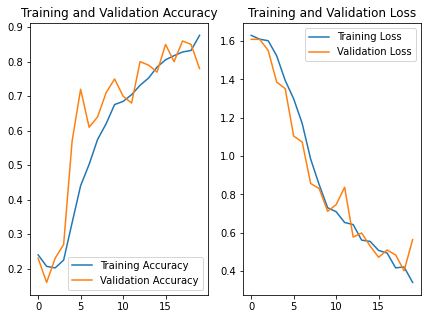

In [ ]:
# Train model and plot performance
model3D_5_hist = model3D_5_obj.train(model3D_5)
plot_model_outcome(model3D_5_hist)

# Delete the objects and variables to save memory!
del model3D_5_obj, model3D_5_hist, model3D_5

##### Model 5 Training Summary
Metrics:
* Training Accuracy - **83.26** %
* Training Loss - **0.42**
* Validation Accuracy - **85** %
* Validation Loss - **0.40**

This model ran faster and metrics is acceptable. Sometimes dropout layer affects training dataset regularization such that the accuracy can go lower than validation accuracy.<br>
Validation accuracy keeps on dropping and increasing per epoch. This could mean the model is trying to get stable results, eventhough the loss of both training and validation dataset matches.

## Model 6

#### Model Design
* Two convolution layers (Conv3D) having 16, 32, 64 and 128 kernels with Relu activation function is designed. The output image resolution is kept same.
* After two convolution layer:
    * A max pooling layer (MaxPooling3D) is added to reduce dimensionality.
    * A dropout layer (Dropout) is added to reguralize and avoid overfitting of model
* The output convolution-max pooling layer is flattened using Flatten layer.
* Two fully connected layers (Dense) with Relu activation function is added. And two dropout layer is added in between them. Both dense layers have same `x` neurons.
* Finally a fully connected layer with 5 neurons with Softmax activation function is used to classify the sequence in to one of the 5 Gesture classes.

In [ ]:
# Child class inherits properties from base abstract class and define the model creation functio 'create'
class Model3D_2(BaseModel):
    # Model function
    # arguments:
    #    kernel_size (Kernel Filter Shape : Default((3, 3, 3)))
    #    pool_size (Pool Size Shape : Default((2, 2, 2)))
    #    fc_neurons (Number of neurons in Fully Connected Layer : Default(64))
    #    dropout_rate (Dropout rate in Dropout Layer : Default(0.25))
    #    optimiser (Optimiser to be used : Default(Adam with Learning Rate 0.001))
    def create(self, 
               kernel_size = (3, 3, 3), 
               pool_size = (2, 2, 2), 
               fc_neurons = 64, 
               dropout_rate = 0.25, 
               optimiser = tf.optimizers.Adam()):
        model = Sequential()
        
        # First 1st conv layer
        model.add(Conv3D(16, kernel_size=kernel_size, padding='same', activation='relu',
                 input_shape=(self.imgs_to_use, self.img_height, self.img_width, self.channels)))
        # First 2nd conv layer
        model.add(Conv3D(16, kernel_size=kernel_size, padding='same', activation='relu'))
        # First max pool layer
        model.add(MaxPooling3D(pool_size=pool_size))
        # First Dropout layer
        model.add(Dropout(dropout_rate))
        
        # Second 1st conv layer
        model.add(Conv3D(32, kernel_size=kernel_size, padding='same', activation='relu'))
        # Second 2nd conv layer
        model.add(Conv3D(32, kernel_size=kernel_size, padding='same', activation='relu'))
        # Second max pool layer
        model.add(MaxPooling3D(pool_size=pool_size))
        # Second Dropout layer
        model.add(Dropout(dropout_rate))

        # Third 1st conv layer
        model.add(Conv3D(64, kernel_size=kernel_size, padding='same', activation='relu'))
        # Third 2nd conv layer
        model.add(Conv3D(64, kernel_size=kernel_size, padding='same', activation='relu'))
        # Third max pool layer
        model.add(MaxPooling3D(pool_size=pool_size))
        # Third Dropout layer
        model.add(Dropout(dropout_rate))

        # Fourth 1st conv layer
        model.add(Conv3D(128, kernel_size=kernel_size, padding='same', activation='relu'))
        # Fourth 2nd conv layer
        model.add(Conv3D(128, kernel_size=kernel_size, padding='same', activation='relu'))
        # Fourth max pool layer
        model.add(MaxPooling3D(pool_size=pool_size))
        # Fourth Dropout layer
        model.add(Dropout(dropout_rate))

        # Flatten layer
        model.add(Flatten())

        # Dense layer or fully connected layer
        model.add(Dense(fc_neurons, activation='relu'))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Dense layer or fully connected layer
        model.add(Dense(fc_neurons, activation='relu'))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Softmax layer
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

#### Model 6 Summary
* Image resolution of 120x120 is chosen and 20 images per Video is taken for training the model. 39 sequences per 17 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3, 3), Max Pool shape is (2, 2, 2), Two dense layer with 128 neurons, dropout rate is 0.25 and optimizer is Adam with learning rate 0.001

`Similar to model 1 param calculation, we can calculate the output shape and trainable params of this model as well.`

In [ ]:
# Create a object of Model3D_2()
# Params:
#   Image Shape - (120, 120)
#   Batch Size - 17
#   Epochs - 20
#   Images per Video - 20
#   Fully Connected Neurons - 128
model3D_6_obj = Model3D_2()
model3D_6_obj.init(fpath)
model3D_6_obj.params(img_height = 120, img_width = 120, batch_size = 17, num_epochs = 20, imgs_to_use = 20)
model3D_6 = model3D_6_obj.create(fc_neurons = 128)

Total training dataset :  663
Total validation dataset :  100
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 conv3d_21 (Conv3D)          (None, 20, 120, 120, 16)  6928      
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 10, 60, 60, 16)    0         
                                                                 
 conv3d_22 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 conv3d_23 (Conv3D)          (None, 10, 60, 60, 32)    276

Source path =  datasets/Project_data/train ; batch size = 17
Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 1.6041 - categorical_accuracy: 0.1810Source path =  datasets/Project_data/val ; batch size = 17

Epoch 00001: val_loss improved from inf to 1.46891, saving model to model_init_2023-02-1219_27_41.633186/model-00001-1.60407-0.18100-1.46891-0.26000.h5
39/39 [==============================] - 106s 3s/step - loss: 1.6041 - categorical_accuracy: 0.1810 - val_loss: 1.4689 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 1.6050 - categorical_accuracy: 0.2353
Epoch 00002: val_loss did not improve from 1.46891
39/39 [==============================] - 105s 3s/step - loss: 1.6050 - categorical_accuracy: 0.2353 - val_loss: 1.6109 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 1.6141 - categorical_accuracy: 0.1976
Epoch 00003: val_loss did

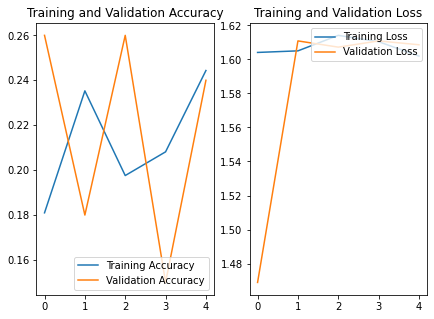

In [ ]:
# Train model and plot performance
model3D_6_hist = model3D_6_obj.train(model3D_6)
plot_model_outcome(model3D_6_hist)

# Delete the objects and variables to save memory!
del model3D_6_obj, model3D_6_hist, model3D_6

##### Model 6 Training Summary
Metrics:
* Training Accuracy - **18.10** %
* Training Loss - **1.60**
* Validation Accuracy - **26** %
* Validation Loss - **1.47**

Clearly adding more convolution doesn't help in model training. After first epoch, validation loss didn't improve. **This model is underfittig and the worst!**

## Model 7

We tried model designing with 3D convolution layer and found some models giving good results! Now let's focus on 2D Convolution Neural Nework (CNN) + Recurrent Neural Network (RNN) model designing and verify its performance.

#### Model Design
* A convolution layer (Conv2D) having 16, 32, 64 and 128 kernels with Relu activation function is designed. The output image resolution is kept same.
* Between each convolution layer:
    * A max pooling layer (MaxPooling3D) is added to reduce dimensionality.
    * A dropout layer (Dropout) is added to reguralize and avoid overfitting of model
* The output convolution-max pooling layer is flattened using Flatten layer.
* All CNN layers are wrapped in time distributed layer to feed as temporal slice of input.
* An LSTM (Long short-term memory) layer is added with `x` lstm cells. A dropout layer is added afterwards.
* A fully connected layers (Dense) with Relu activation function is added. The dense layer have `x` neurons and a dropout layer is added afterwards.
* Finally a fully connected layer with 5 neurons with Softmax activation function is used to classify the sequence in to one of the 5 Gesture classes.

In [8]:
# Child class inherits properties from base abstract class and define the model creation functio 'create'
class ModelLSTM_1(BaseModel):
    # Model function
    # arguments:
    #    kernel_size (Kernel Filter Shape : Default((3, 3)))
    #    pool_size (Pool Size Shape : Default((2, 2)))
    #    lstm_cells (Number of cells in LSTM : Default(64))
    #    fc_neurons (Number of neurons in Fully Connected Layer : Default(64))
    #    dropout_rate (Dropout rate in Dropout Layer : Default(0.25))
    #    optimiser (Optimiser to be used : Default(Adam with Learning Rate 0.001))
    def create(self, 
               kernel_size = (3, 3), 
               pool_size = (2, 2), 
               lstm_cells = 64, 
               fc_neurons = 64, 
               dropout_rate = 0.25, 
               optimiser = tf.optimizers.Adam()):
        model = Sequential()
        
        # First conv layer
        model.add(TimeDistributed(Conv2D(16, kernel_size=kernel_size, padding='same', activation='relu'),
                 input_shape=(self.imgs_to_use, self.img_height, self.img_width, self.channels)))
        # First max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # First Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))
        
        # Second conv layer
        model.add(TimeDistributed(Conv2D(32, kernel_size=kernel_size, padding='same', activation='relu')))
        # Second max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # Second Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))

        # Third conv layer
        model.add(TimeDistributed(Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')))
        # Third max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # Third Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))

        # Fourth conv layer
        model.add(TimeDistributed(Conv2D(128, kernel_size=kernel_size, padding='same', activation='relu')))
        # Fourth max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # Fourth Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))

        # Flatten layer
        model.add(TimeDistributed(Flatten()))

        # LSTM Layer
        model.add(LSTM(lstm_cells))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Dense layer or fully connected layer
        model.add(Dense(fc_neurons, activation='relu'))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Softmax layer
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

#### Model 7 Summary
* Image resolution of 120x120 is chosen and 20 images per Video is taken for training the model. 34 sequences per 20 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3), Max Pool shape is (2, 2), 128 LSTM cells, 128 neurons in dense layer, dropout rate is 0.25 and optimizer is Adam with learning rate 0.001

In [9]:
# Create a object of ModelLSTM_1()
# Params:
#   Image Shape - (120, 120)
#   Batch Size - 20
#   Epochs - 20
#   Images per Video - 20
#   LSTM Cells - 128
#   Fully Connected Neurons - 128
modelLSTM_1_obj = ModelLSTM_1()
modelLSTM_1_obj.init(fpath)
modelLSTM_1_obj.params(img_height = 120, img_width = 120, batch_size = 20, num_epochs = 20, imgs_to_use = 20)
modelLSTM_1 = modelLSTM_1_obj.create(lstm_cells = 128, fc_neurons = 128)

Total training dataset :  663
Total validation dataset :  100


2023-02-13 12:10:51.485121: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-13 12:10:51.485204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 30, 30, 32)   0

##### Model 7 Param Calculation
`Similar to model 1 param calculation, we can calculate the output shape and trainable params of this model as well.`
* 2D CNN layer param calculation pretty much straight forward as explained in Model 1 param calculation.
* Only difference is that the images to use per video remains same through out CNN layer due to time distributed layer.
* LSTM param calculation = 4 functions x (LSTM cells x (Input Shape + LSTM cells + 1 Bias))
                         = 4 x (128 x (6272 + 128 + 1) , where 6272 is the input shape to LSTM cell.
                         = 3277312
* LSTM layer output shape is just LSTM cells feature. Hence Input (Batch size, 20, 6272) becomes (Batch size, 128)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/20


2023-02-13 12:11:07.117906: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6535 - categorical_accuracy: 0.2308Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.65555, saving model to model_init_2023-02-1312_11_01.980331/model-00001-1.65348-0.23077-1.65555-0.21000.h5
34/34 [==============================] - 108s 3s/step - loss: 1.6535 - categorical_accuracy: 0.2308 - val_loss: 1.6555 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5558 - categorical_accuracy: 0.2881
Epoch 00002: val_loss did not improve from 1.65555
34/34 [==============================] - 104s 3s/step - loss: 1.5558 - categorical_accuracy: 0.2881 - val_loss: 1.8243 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3990 - categorical_accuracy: 0.3906
Epoch 00003: val_loss did not improve from 1.65555
34/34 [==============================] - 103s 

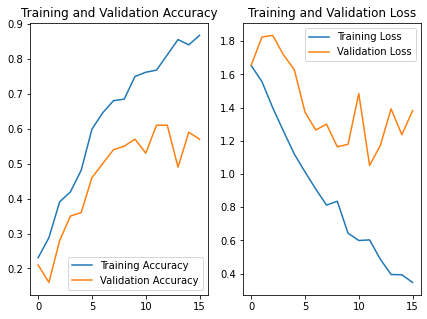

In [10]:
# Train model and plot performance
modelLSTM_1_hist = modelLSTM_1_obj.train(modelLSTM_1)
plot_model_outcome(modelLSTM_1_hist)

# Delete the objects and variables to save memory!
del modelLSTM_1_obj, modelLSTM_1_hist, modelLSTM_1

##### Model 7 Training Summary
Metrics:
* Training Accuracy - **86.73** %
* Training Loss - **0.35**
* Validation Accuracy - **57** %
* Validation Loss - **1.38**

Clearly the **model is overfitted** and didn't improve validation loss!

## Model 8

#### Model Design
* A convolution layer (Conv2D) having 16, 32, 64 and 128 kernels with Relu activation function is designed. The output image resolution is kept same.
* Between each convolution layer:
    * A max pooling layer (MaxPooling3D) is added to reduce dimensionality.
    * A dropout layer (Dropout) is added to reguralize and avoid overfitting of model
* The output convolution-max pooling layer is flattened using Flatten layer.
* All CNN layers are wrapped in time distributed layer to feed as temporal slice of input.
* An GRU (Gated recurrent unit) layer is added with `x` lstm cells. A dropout layer is added afterwards.
* A fully connected layers (Dense) with Relu activation function is added. The dense layer have `x` neurons and a dropout layer is added afterwards.
* Finally a fully connected layer with 5 neurons with Softmax activation function is used to classify the sequence in to one of the 5 Gesture classes.

In [ ]:
# Child class inherits properties from base abstract class and define the model creation functio 'create'
class ModelGRU_1(BaseModel):
    # Model function
    # arguments:
    #    kernel_size (Kernel Filter Shape : Default((3, 3)))
    #    pool_size (Pool Size Shape : Default((2, 2)))
    #    gru_cells (Number of cells in LSTM : Default(64))
    #    fc_neurons (Number of neurons in Fully Connected Layer : Default(64))
    #    dropout_rate (Dropout rate in Dropout Layer : Default(0.25))
    #    optimiser (Optimiser to be used : Default(Adam with Learning Rate 0.001))
    def create(self, 
               kernel_size = (3, 3), 
               pool_size = (2, 2), 
               gru_cells = 64, 
               fc_neurons = 64, 
               dropout_rate = 0.25, 
               optimiser = tf.optimizers.Adam()):
        model = Sequential()
        
        # First conv layer
        model.add(TimeDistributed(Conv2D(16, kernel_size=kernel_size, padding='same', activation='relu'),
                 input_shape=(self.imgs_to_use, self.img_height, self.img_width, self.channels)))
        # First max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # First Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))
        
        # Second conv layer
        model.add(TimeDistributed(Conv2D(32, kernel_size=kernel_size, padding='same', activation='relu')))
        # Second max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # Second Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))

        # Third conv layer
        model.add(TimeDistributed(Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')))
        # Third max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # Third Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))

        # Fourth conv layer
        model.add(TimeDistributed(Conv2D(128, kernel_size=kernel_size, padding='same', activation='relu')))
        # Fourth max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # Fourth Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))

        # Flatten layer
        model.add(TimeDistributed(Flatten()))

        # GRU Layer
        model.add(GRU(gru_cells))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Dense layer or fully connected layer
        model.add(Dense(fc_neurons, activation='relu'))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Softmax layer
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

#### Model 8 Summary
* Image resolution of 120x120 is chosen and 20 images per Video is taken for training the model. 34 sequences per 20 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3), Max Pool shape is (2, 2), 128 GRU cells, 128 neurons in dense layer, dropout rate is 0.25 and optimizer is Adam with learning rate 0.001

In [ ]:
# Create a object of ModelGRU_1()
# Params:
#   Image Shape - (120, 120)
#   Batch Size - 20
#   Epochs - 20
#   Images per Video - 20
#   GRU Cells - 128
#   Fully Connected Neurons - 128
modelGRU_1_obj = ModelGRU_1()
modelGRU_1_obj.init(fpath)
modelGRU_1_obj.params(img_height = 120, img_width = 120, batch_size = 20, num_epochs = 20, imgs_to_use = 20)
modelGRU_1 = modelGRU_1_obj.create(gru_cells = 128, fc_neurons = 128)

Total training dataset :  663
Total validation dataset :  100
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                          

##### Model 8 Param Calculation
`Similar to model 1 param calculation, we can calculate the output shape and trainable params of this model as well.`
* 2D CNN layer param calculation pretty much straight forward as explained in Model 1 param calculation.
* Only difference is that the images to use per video remains same through out CNN layer due to time distributed layer.
* GRU param calculation = 4 functions x (GRU cells x (Input Shape + GRU cells + 2))
                         = 4 x (128 x (6272 + 128 + 2) , where 6272 is the input shape to GRU cell.
                         = 2458368
* GRU layer output shape is just GRU cells feature. Hence Input (Batch size, 20, 6272) becomes (Batch size, 128)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6233 - categorical_accuracy: 0.2428Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.60260, saving model to model_init_2023-02-1312_38_46.790419/model-00001-1.62330-0.24284-1.60260-0.26000.h5
34/34 [==============================] - 106s 3s/step - loss: 1.6233 - categorical_accuracy: 0.2428 - val_loss: 1.6026 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5461 - categorical_accuracy: 0.2609
Epoch 00002: val_loss improved from 1.60260 to 1.40148, saving model to model_init_2023-02-1312_38_46.790419/model-00002-1.54609-0.26094-1.40148-0.49000.h5
34/34 [==============================] - 104s 3s/step - loss: 1.5461 - categorical_accuracy: 0.2609 - val_loss: 1.4015 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 3/20
34/34 [========

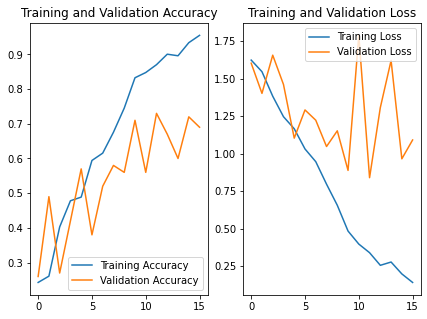

In [ ]:
# Train model and plot performance
modelGRU_1_hist = modelGRU_1_obj.train(modelGRU_1)
plot_model_outcome(modelGRU_1_hist)

# Delete the objects and variables to save memory!
del modelGRU_1_obj, modelGRU_1_hist, modelGRU_1

##### Model 8 Training Summary
Metrics:
* Training Accuracy - **95.48** %
* Training Loss - **0.14**
* Validation Accuracy - **69** %
* Validation Loss - **1.09**

Clearly the **model is overfitted** and didn't improve validation loss! Loss is better than LSTM model.

## Model 9
Model 9 is Model 8 with Augmentation (slightly cropped of images are also added along with batch.)

In [ ]:
# Create a object of ModelGRU_1()
# Params:
#   Image Shape - (120, 120)
#   Batch Size - 20
#   Epochs - 20
#   Images per Video - 20
#   GRU Cells - 128
#   Fully Connected Neurons - 128
modelGRU_1_aug_obj = ModelGRU_1()
modelGRU_1_aug_obj.init(fpath)
modelGRU_1_aug_obj.params(img_height = 120, img_width = 120, batch_size = 20, num_epochs = 20, imgs_to_use = 20)
modelGRU_1_aug = modelGRU_1_aug_obj.create(gru_cells = 128, fc_neurons = 128)

Total training dataset :  663
Total validation dataset :  100
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                          

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6254 - categorical_accuracy: 0.2232Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.60434, saving model to model_init_2023-02-1313_06_33.737880/model-00001-1.62542-0.22323-1.60434-0.28000.h5
34/34 [==============================] - 188s 6s/step - loss: 1.6254 - categorical_accuracy: 0.2232 - val_loss: 1.6043 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5046 - categorical_accuracy: 0.3130
Epoch 00002: val_loss improved from 1.60434 to 1.43718, saving model to model_init_2023-02-1313_06_33.737880/model-00002-1.50457-0.31297-1.43718-0.36000.h5
34/34 [==============================] - 187s 6s/step - loss: 1.5046 - categorical_accuracy: 0.3130 - val_loss: 1.4372 - val_categorical_accuracy: 0.3600 - lr: 2.0000e-04
Epoch 3/20
34/34 [

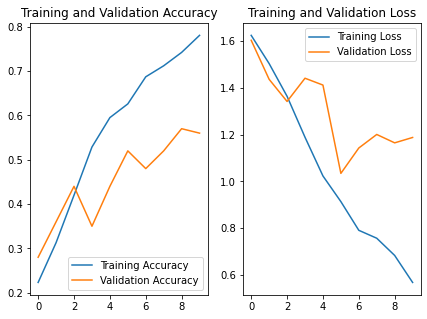

In [ ]:
# Train model and plot performance
modelGRU_1_aug_hist = modelGRU_1_aug_obj.train(modelGRU_1_aug, augment = True)
plot_model_outcome(modelGRU_1_aug_hist)

# Delete the objects and variables to save memory!
del modelGRU_1_aug_obj, modelGRU_1_aug_hist, modelGRU_1_aug

##### Model 9 Training Summary
Metrics:
* Training Accuracy - **78.05** %
* Training Loss - **0.57**
* Validation Accuracy - **56** %
* Validation Loss - **1.19**

Clearly the **model is overfitted** and didn't improve validation loss! Adding augmentation reduced the accuracy, so we can clearly see that augmentation helps in one way.

## Model 10

We designed both 3D CNN and (CNN + RNN) models. Now let's see the effect of pre-trained CNN models + RNN.
To **reduce the memory space and execution time**, we chose MobileNetV2. Since model should run faster in real time and take less space, MobileNetV2 is the best choice. Other pre-trained models have large number of parameters and can't be feasible in real-time requirement.

#### Model Design
* MobileNetV2 layer is added. The final dense layers of this pre-trained model is chopped off using **include_top = False** option. **Training weights of MobileNetV2 is disabled**.
* A max pooling layer (MaxPooling3D) is added to reduce dimensionality.
* A dropout layer (Dropout) is added to reguralize and avoid overfitting of model.
* The output convolution-max pooling layer is flattened using Flatten layer.
* All CNN layers are wrapped in time distributed layer to feed as temporal slice of input.
* An GRU (Gated recurrent unit) layer is added with `x` lstm cells. A dropout layer is added afterwards.
* A fully connected layers (Dense) with Relu activation function is added. The dense layer have `x` neurons and a dropout layer is added afterwards.
* Finally a fully connected layer with 5 neurons with Softmax activation function is used to classify the sequence in to one of the 5 Gesture classes.

In [9]:
mobile = tf.keras.applications.MobileNetV2(include_top = False)

# Child class inherits properties from base abstract class and define the model creation functio 'create'
class ModelGRU_2(BaseModel):
    # Model function
    # arguments:
    #    kernel_size (Kernel Filter Shape : Default((3, 3)))
    #    pool_size (Pool Size Shape : Default((2, 2)))
    #    gru_cells (Number of cells in GRU : Default(64))
    #    fc_neurons (Number of neurons in Fully Connected Layer : Default(64))
    #    dropout_rate (Dropout rate in Dropout Layer : Default(0.25))
    #    optimiser (Optimiser to be used : Default(Adam with Learning Rate 0.001))
    def create(self, 
               kernel_size = (3, 3), 
               pool_size = (2, 2), 
               gru_cells = 64, 
               fc_neurons = 64, 
               dropout_rate = 0.25, 
               optimiser = tf.optimizers.Adam()):
        
        model = Sequential()
        model.add(TimeDistributed(mobile, input_shape=(self.imgs_to_use, self.img_height, self.img_width, self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
        
        # First max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # First Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))
        
         # Flatten layer
        model.add(TimeDistributed(Flatten()))

        # GRU Layer
        model.add(GRU(gru_cells))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Dense layer or fully connected layer
        model.add(Dense(fc_neurons, activation='relu'))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Softmax layer
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

#### Model 10 Summary
* Image resolution of 120x120 is chosen and 16 images per Video is taken for training the model. 133 sequences per 5 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3), Max Pool shape is (2, 2), 128 LSTM cells, 128 neurons in dense layer, dropout rate is 0.25 and optimizer is Adam with learning rate 0.001
* Augmentation - slightly cropped of images are also added along with batch.

`Similar to model 8 param calculation, we can calculate the output shape and trainable params of this model as well.`

* Since layers of MobileNetV2 is disabled for training, we can see that the 2,257,984 parmas of MobileNetV2 as Non-trainable in model summary.

In [10]:
# Create a object of ModelGRU_2()
# Params:
#   Image Shape - (120, 120)
#   Batch Size - 5
#   Epochs - 20
#   Images per Video - 16
#   GRU Cells - 128
#   Fully Connected Neurons - 128
modelGRU_2_obj = ModelGRU_2()
modelGRU_2_obj.init(fpath)
modelGRU_2_obj.params(img_height = 120, img_width = 120, batch_size = 5, num_epochs = 20, imgs_to_use = 16)
modelGRU_2 = modelGRU_2_obj.create(gru_cells = 128, fc_neurons = 128)

Total training dataset :  663
Total validation dataset :  100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1280)   2257984   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 1, 1, 1280)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1280)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1280)         0         
 tributed)                                                       
                                                            

Source path =  datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4549 - categorical_accuracy: 0.3793Source path =  datasets/Project_data/val ; batch size = 5

Epoch 00001: val_loss improved from inf to 0.97134, saving model to model_init_2023-02-1313_38_00.787330/model-00001-1.45494-0.37934-0.97134-0.64000.h5
133/133 [==============================] - 157s 1s/step - loss: 1.4549 - categorical_accuracy: 0.3793 - val_loss: 0.9713 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9944 - categorical_accuracy: 0.5995
Epoch 00002: val_loss improved from 0.97134 to 0.74721, saving model to model_init_2023-02-1313_38_00.787330/model-00002-0.99444-0.59955-0.74721-0.70000.h5
133/133 [==============================] - 153s 1s/step - loss: 0.9944 - categorical_accuracy: 0.5995 - val_loss: 0.7472 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/20
133/133 [

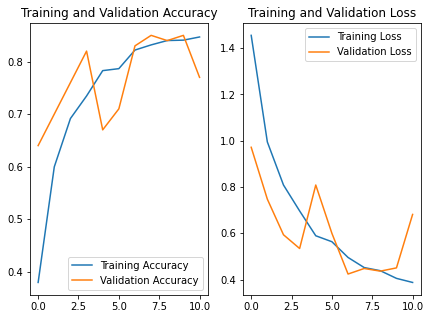

In [ ]:
# Train model and plot performance
modelGRU_2_hist = modelGRU_2_obj.train(modelGRU_2, augment = True)
plot_model_outcome(modelGRU_2_hist)

# Delete the objects and variables to save memory!
del modelGRU_2_obj, modelGRU_2_hist, modelGRU_2

##### Model 10 Training Summary
Metrics:
* Training Accuracy - **82.2** %
* Training Loss - **0.5**
* Validation Accuracy - **83** %
* Validation Loss - **0.42**

Best model is saved but as epoch increased, model performance became worse. Eventhough the metrics is promising, it might not give good results for test data.

## Model 11

#### Model Design
* MobileNetV2 layer is added. The final dense layers of this pre-trained model is chopped off using **include_top = False** option. **Training weights of MobileNetV2 is enabled**.
* A max pooling layer (MaxPooling3D) is added to reduce dimensionality.
* A dropout layer (Dropout) is added to reguralize and avoid overfitting of model.
* The output convolution-max pooling layer is flattened using Flatten layer.
* All CNN layers are wrapped in time distributed layer to feed as temporal slice of input.
* An GRU (Gated recurrent unit) layer is added with `x` lstm cells. A dropout layer is added afterwards.
* A fully connected layers (Dense) with Relu activation function is added. The dense layer have `x` neurons and a dropout layer is added afterwards.
* Finally a fully connected layer with 5 neurons with Softmax activation function is used to classify the sequence in to one of the 5 Gesture classes.

In [11]:
mobile = tf.keras.applications.MobileNetV2(include_top = False)

# Child class inherits properties from base abstract class and define the model creation functio 'create'
class ModelGRU_3(BaseModel):
    # Model function
    # arguments:
    #    kernel_size (Kernel Filter Shape : Default((3, 3)))
    #    pool_size (Pool Size Shape : Default((2, 2)))
    #    gru_cells (Number of cells in GRU : Default(64))
    #    fc_neurons (Number of neurons in Fully Connected Layer : Default(64))
    #    dropout_rate (Dropout rate in Dropout Layer : Default(0.25))
    #    optimiser (Optimiser to be used : Default(Adam with Learning Rate 0.001))
    def create(self, 
               kernel_size = (3, 3), 
               pool_size = (2, 2), 
               gru_cells = 64, 
               fc_neurons = 64, 
               dropout_rate = 0.25, 
               optimiser = tf.optimizers.Adam()):
        
        model = Sequential()
        model.add(TimeDistributed(mobile, input_shape=(self.imgs_to_use, self.img_height, self.img_width, self.channels)))

        # First max pool layer
        model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size)))
        # First Dropout layer
        model.add(TimeDistributed(Dropout(dropout_rate)))

         # Flatten layer
        model.add(TimeDistributed(Flatten()))

        # GRU Layer
        model.add(GRU(gru_cells))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Dense layer or fully connected layer
        model.add(Dense(fc_neurons, activation='relu'))
        # Dropout layer with dropoutRate
        model.add(Dropout(dropout_rate))

        # Softmax layer
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

#### Model 11 Summary
* Image resolution of 120x120 is chosen and 16 images per Video is taken for training the model. 133 sequences per 5 batches will be fed to the model per 20 epochs!
* Kernel shape is (3, 3), Max Pool shape is (2, 2), 128 LSTM cells, 128 neurons in dense layer, dropout rate is 0.25 and optimizer is Adam with learning rate 0.001
* Augmentation - slightly cropped of images are also added along with batch.

`Similar to model 8 param calculation, we can calculate the output shape and trainable params of this model as well.`

* Since layers of MobileNetV2 is enabled for training, we can see that the hidden layer parmas of MobileNetV2 is also included in the model summary as trainable!

In [ ]:
# Create a object of ModelGRU_3()
# Params:
#   Image Shape - (120, 120)
#   Batch Size - 5
#   Epochs - 20
#   Images per Video - 16
#   GRU Cells - 128
#   Fully Connected Neurons - 128
modelGRU_3_obj = ModelGRU_3()
modelGRU_3_obj.init(fpath)
modelGRU_3_obj.params(img_height = 120, img_width = 120, batch_size = 5, num_epochs = 20, imgs_to_use = 16)
modelGRU_3 = modelGRU_3_obj.create(gru_cells = 128, fc_neurons = 128)

Total training dataset :  663
Total validation dataset :  100
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_43 (TimeDi  (None, 16, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 16, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 16, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 16, 1280)         0         
 stributed)                                                      
                                                          

Source path =  datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1782 - categorical_accuracy: 0.5332Source path =  datasets/Project_data/val ; batch size = 5

Epoch 00001: val_loss improved from inf to 1.65766, saving model to model_init_2023-02-1314_06_07.085500/model-00001-1.17821-0.53318-1.65766-0.23000.h5
133/133 [==============================] - 160s 1s/step - loss: 1.1782 - categorical_accuracy: 0.5332 - val_loss: 1.6577 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6731 - categorical_accuracy: 0.7707
Epoch 00002: val_loss improved from 1.65766 to 0.96239, saving model to model_init_2023-02-1314_06_07.085500/model-00002-0.67313-0.77074-0.96239-0.64000.h5
133/133 [==============================] - 153s 1s/step - loss: 0.6731 - categorical_accuracy: 0.7707 - val_loss: 0.9624 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 3/20
133/133 [

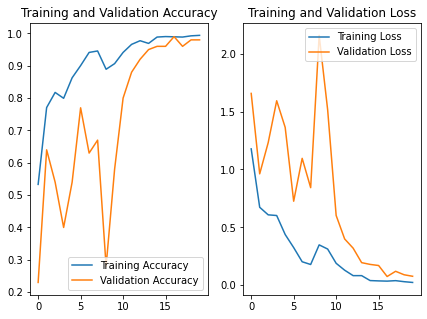

In [ ]:
# Train model and plot performance
modelGRU_3_hist = modelGRU_3_obj.train(modelGRU_3, augment = True, stop_patience = 10)
plot_model_outcome(modelGRU_3_hist)

# Delete the objects and variables to save memory!
del modelGRU_3_obj, modelGRU_3_hist, modelGRU_3

##### Model 11 Training Summary
Metrics:
* Training Accuracy - **98.94** %
* Training Loss - **0.03**
* Validation Accuracy - **99** %
* Validation Loss - **0.07**

**Model looks too GOOD**. After 17th epoch, model didn't improve. From graph plot, we can see how model converged as epoch increased! Only concern is how this model will perform on test data and memory and space is another limitation.

## Testing Models

### Helper Functions for Prediction

In [12]:
# Function to generate Confusion matrix and print report
# arguments:
#    actual (List of actual classes of test data)
#    predicted (List of predicted classes of test data)
#    class_names (Gesture Class Names)
def gen_conf_matrix(actual, predicted, class_names):
    confusion_matrix = metrics.confusion_matrix(actual, predicted)

    # Display confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
    cm_display.plot()
    plt.xticks(rotation = 90)
    plt.show()
    
    # Print classification report
    print(metrics.classification_report(actual, predicted, target_names=class_names))

In [13]:
# Function to load required model and init model class params
# arguments:
#    model_number (Model Number - 1 or 5 or 10 or 11)
def get_model(model_number):
    if model_number == 5:
        print("Model 5 is chosen\n")
        model = load_model("model_init_2023-02-1218_45_12.635075/model-00019-0.42185-0.83258-0.40224-0.85000.h5")
        model_obj = Model3D_1()
        model_obj.init(fpath)
        model_obj.params(img_height = 100, img_width = 100, batch_size = 50, imgs_to_use = 25)
    elif model_number == 10:
        print("Model 10 is chosen\n")
        model = load_model("model_init_2023-02-1313_38_00.787330/model-00007-0.49533-0.82202-0.42371-0.83000.h5")
        model_obj = ModelGRU_2()
        model_obj.init(fpath)
        model_obj.params(img_height = 120, img_width = 120, batch_size = 50, imgs_to_use = 16)
    elif model_number == 11:
        print("Model 11 is chosen\n")
        model = load_model("model_init_2023-02-1314_06_07.085500/model-00017-0.03484-0.98944-0.07473-0.99000.h5")
        model_obj = ModelGRU_3()
        model_obj.init(fpath)
        model_obj.params(img_height = 120, img_width = 120, batch_size = 50, imgs_to_use = 16)
    else:
        print("Model 1 (default) is chosen\n")
        model = load_model("model_init_2023-02-1216_13_47.497290/model-00018-0.33599-0.85822-0.42424-0.85000.h5")
        model_obj = Model3D_1()
        model_obj.init(fpath)
        model_obj.params(img_height = 120, img_width = 160, batch_size = 50, imgs_to_use = 30)
    return model, model_obj

In [14]:
# Class to load required model and predict sequence
# arguments:
#    model_number (Model Number - 1 or 5 or 10 or 11)
#    parent_folder (Main Folder)
#    test_folder (Folder path containing test dataset)
#    test_csv_file (CSV file containing folder information (same as train.csv) - folder name, gesture info and it's index)
class test_model():
    def __init__(self, model_number, parent_folder, test_folder, test_csv_file):       
        self.model, self.test_obj = get_model(model_number)
        test_doc = np.random.permutation(open(test_csv_file).readlines())        
        self.yield_obj = self.test_obj.generator(test_folder, test_doc)
    def evaluate(self):
        # Yield the batch
        self.batch_data, self.batch_labels = next(self.yield_obj)
        # Evaluate
        self.model.evaluate(self.batch_data[:,:,:,:,:])
    def predict(self):
        # Yield the batch
        self.batch_data, self.batch_labels = next(self.yield_obj)
        # Get actual and predicted class
        self.actual_labels = [ np.argmax(t) for t in self.batch_labels ]
        self.predicted_labels = [ np.argmax(t) for t in self.model.predict(self.batch_data[:,:,:,:,:]) ]

#### Testing Model 1

Model 1 (default) is chosen

Total training dataset :  663
Total validation dataset :  100
Source path =  datasets/Project_data/val ; batch size = 50
2/2 [==============================] - 6s 2s/step


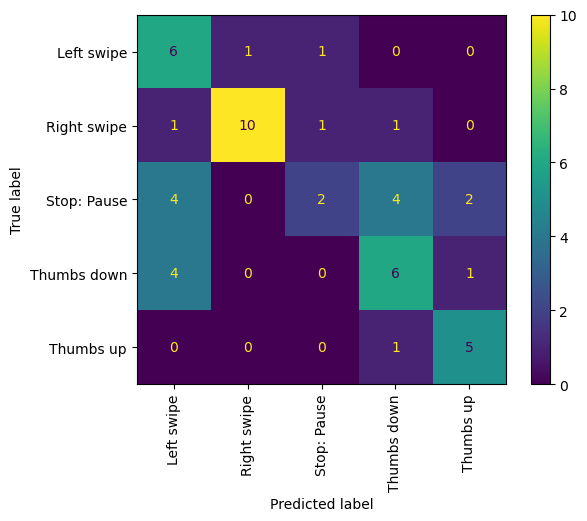

              precision    recall  f1-score   support

  Left swipe       0.40      0.75      0.52         8
 Right swipe       0.91      0.77      0.83        13
 Stop: Pause       0.50      0.17      0.25        12
 Thumbs down       0.50      0.55      0.52        11
   Thumbs up       0.62      0.83      0.71         6

    accuracy                           0.58        50
   macro avg       0.59      0.61      0.57        50
weighted avg       0.61      0.58      0.56        50



In [15]:
# Create test class object for model 1
test_obj = test_model(1, 
                     'datasets/Project_data', # Main folder where data is present
                     'datasets/Project_data/val', # Validation folder
                     'datasets/Project_data/val.csv')

# Predict, display results and delete object
test_obj.predict()
gen_conf_matrix(test_obj.actual_labels, test_obj.predicted_labels, class_names)
del test_obj

#### Testing Model 5

Model 5 is chosen

Total training dataset :  663
Total validation dataset :  100
Source path =  datasets/Project_data/val ; batch size = 50
2/2 [==============================] - 3s 886ms/step


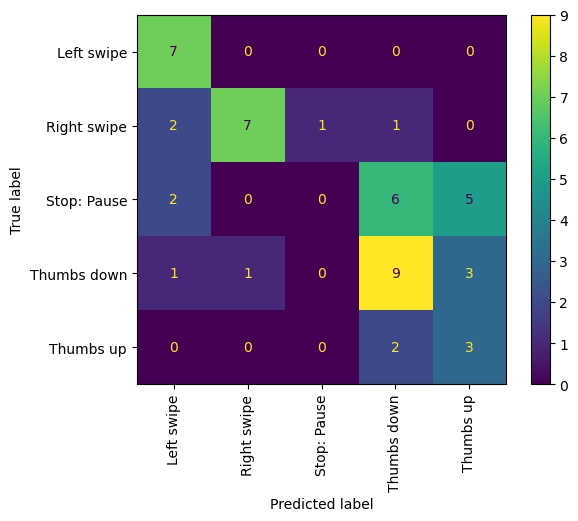

              precision    recall  f1-score   support

  Left swipe       0.58      1.00      0.74         7
 Right swipe       0.88      0.64      0.74        11
 Stop: Pause       0.00      0.00      0.00        13
 Thumbs down       0.50      0.64      0.56        14
   Thumbs up       0.27      0.60      0.37         5

    accuracy                           0.52        50
   macro avg       0.45      0.58      0.48        50
weighted avg       0.44      0.52      0.46        50



In [16]:
# Create test class object for model 5
test_obj = test_model(5, 
                     'datasets/Project_data', # Main folder where data is present
                     'datasets/Project_data/val', # Validation folder
                     'datasets/Project_data/val.csv')

# Predict, display results and delete object
test_obj.predict()
gen_conf_matrix(test_obj.actual_labels, test_obj.predicted_labels, class_names)
del test_obj

#### Testing Model 10

Model 10 is chosen

Total training dataset :  663
Total validation dataset :  100
Source path =  datasets/Project_data/val ; batch size = 50
2/2 [==============================] - 4s 1s/step


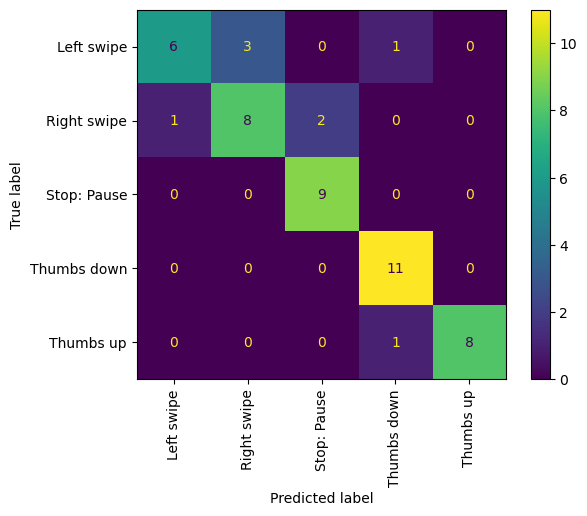

              precision    recall  f1-score   support

  Left swipe       0.86      0.60      0.71        10
 Right swipe       0.73      0.73      0.73        11
 Stop: Pause       0.82      1.00      0.90         9
 Thumbs down       0.85      1.00      0.92        11
   Thumbs up       1.00      0.89      0.94         9

    accuracy                           0.84        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.84      0.84      0.83        50



In [17]:
# Create test class object for model 10
test_obj = test_model(10, 
                     'datasets/Project_data', # Main folder where data is present
                     'datasets/Project_data/val', # Validation folder
                     'datasets/Project_data/val.csv')

# Predict, display results and delete object
test_obj.predict()
gen_conf_matrix(test_obj.actual_labels, test_obj.predicted_labels, class_names)
del test_obj

#### Testing Model 11

Model 11 is chosen

Total training dataset :  663
Total validation dataset :  100
Source path =  datasets/Project_data/val ; batch size = 50
2/2 [==============================] - 5s 1s/step


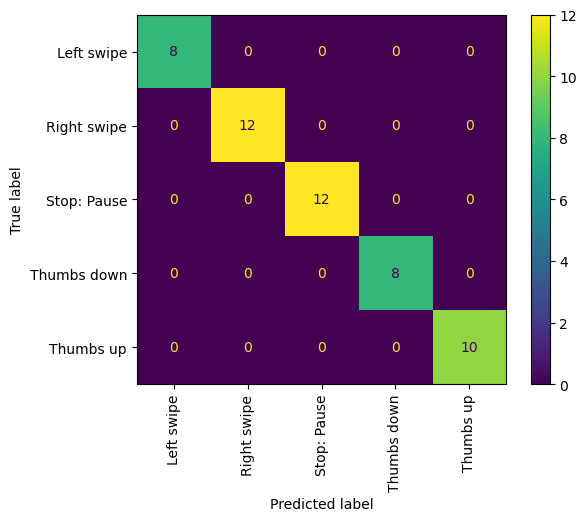

              precision    recall  f1-score   support

  Left swipe       1.00      1.00      1.00         8
 Right swipe       1.00      1.00      1.00        12
 Stop: Pause       1.00      1.00      1.00        12
 Thumbs down       1.00      1.00      1.00         8
   Thumbs up       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [18]:
# Create test class object for model 11
test_obj = test_model(11, 
                     'datasets/Project_data', # Main folder where data is present
                     'datasets/Project_data/val', # Validation folder
                     'datasets/Project_data/val.csv')

# Predict, display results and delete object
test_obj.predict()
gen_conf_matrix(test_obj.actual_labels, test_obj.predicted_labels, class_names)
del test_obj

## Conclusion

* Model 11 gave superb results in prediction. Hence we will choose this model as our final model.
* Model 10 gives decent prediction result!
* Model 1 and model 5 gives average prediction and model 5 ran faster than model 1.
* Both models 1 and 5 have very less trainable parameters when compared to model 10 and 11.
* Both models 1 and 5 have less accracy and close to 50 % in prediction. Hence, it is not wise to use this for test data or real-time prediction!

## Prediction

We will use **model 11** for prediction. For easiness, we will copy the model outside for users to predict.

In [19]:
# Instialize the model parms
model_obj = ModelGRU_3()
model_obj.init('datasets/Project_data')
model_obj.params(img_height = 120, img_width = 120, batch_size = 50, imgs_to_use = 16)

Total training dataset :  663
Total validation dataset :  100


In [20]:
# Read CSV file and activate generator
test_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())        
yield_obj = model_obj.generator('datasets/Project_data/val', test_doc)

In [22]:
# Load the required model - model 11
model = load_model('model-00017-0.03484-0.98944-0.07473-0.99000.h5')

In [23]:
# Yield the batch
batch_data, batch_labels = next(yield_obj)
# Get actual and predicted class
actual_labels = [ np.argmax(t) for t in batch_labels ]
predicted_labels = [ np.argmax(t) for t in model.predict(batch_data[:,:,:,:,:]) ]

2/2 [==============================] - 5s 997ms/step


In [26]:
# Print actual and predicted class
print('Actual Labels :\n\n', actual_labels)
print('\n\n\nPredicted Labels :\n\n', predicted_labels)

Actual Labels :

 [4, 3, 0, 1, 4, 0, 3, 0, 4, 2, 1, 1, 3, 2, 4, 3, 2, 2, 1, 1, 0, 1, 0, 0, 2, 4, 2, 1, 2, 4, 2, 2, 4, 3, 3, 2, 0, 2, 4, 2, 1, 0, 1, 3, 4, 2, 2, 0, 3, 3]



Predicted Labels :

 [4, 3, 0, 1, 4, 0, 3, 0, 4, 3, 1, 1, 3, 2, 4, 3, 2, 2, 1, 1, 0, 1, 0, 0, 2, 4, 2, 1, 2, 4, 2, 2, 4, 3, 3, 2, 0, 2, 4, 2, 1, 0, 1, 3, 4, 2, 2, 0, 3, 3]


<hr style="border:1px solid red">